In [2]:
%load_ext autoreload
%autoreload 2

import copy
import os
import torch
import numpy as np
import pythreejs as pjs
import warnings
warnings.filterwarnings('ignore')

from matplotlib.cm import get_cmap
from tqdm.notebook import tqdm
from PIL import Image
from IPython.core.display import display

os.chdir('..')
np.set_printoptions(precision=4)
!pwd

/home/lcw/workspace/panosupervised


In [3]:
import numpy as np
from collections import defaultdict

import torch
import torch.nn.functional as F

from vidar.arch.losses.MultiCamPhotometricLoss import MultiCamPhotometricLoss
from vidar.arch.losses.MultiViewPhotometricLoss import calc_smoothness
from vidar.arch.networks.layers.panodepth.flow_reversal import FlowReversal
from vidar.datasets.PanoCamOuroborosDataset import PANO_CAMERA_NAME
from vidar.geometry.camera import Camera
from vidar.geometry.camera_pano import PanoCamera
from vidar.utils.config import cfg_has
from vidar.utils.depth import inv2depth, depth2inv
from vidar.utils.tensor import match_scales, make_same_resolution
from vidar.utils.viz import viz_photo
from vidar.utils.write import viz_depth

In [4]:
from common import to_numpy, to_uint8, visualize_3d, visualize_3d_list

In [5]:
from vidar.utils.config import read_config

config = read_config('configs/papers/panosup/train_sup.yaml')

config.arch.networks.depth.decoder.out_shape = [128, 1024]
# config.arch.networks.depth.decoder.out_shape = [64, 512]
    
# Resize depth for easy debugging
# config.datasets.train.augmentation.resize_supervision = True
# config.datasets.train.dataloader.num_workers = 0
config.datasets.validation.labels += ['lidar']
config.datasets.validation.dataloader.batch_size = 1
config.datasets.validation.dataloader.num_workers = 0

In [6]:
from vidar.utils.setup import setup_dataset, setup_dataloader

dataset = setup_dataset(config.datasets.train, verbose=True)
dataloader = setup_dataloader(dataset, config.datasets.train.dataloader, 'train')

# dataset = setup_dataset(config.datasets.validation, verbose=True)
# dataloader = setup_dataloader(dataset, config.datasets.validation.dataloader, 'val')

#### PanoCamOuroboros: 
	 98 samples (x1) | context [-1,1] | cameras [1,5,6,7,8,9] | labels ['depth','pose']
	 | augmentation Config(jittering=[0.2,0.2,0.2,0.05],resize=[384,640]) | (PanoCam) panocam_56_0_150_z_-02_+02
#### DataLoader (PanoCamOuroborosDataset, train): 
	 batch_size: 2 (x 1) | pin_memory: True | num_workers: 2 | shuffle: True


In [7]:
from torch.utils.data.dataloader import default_collate

batch_from_loader = default_collate([dataset[0][0]])
batch_from_loader.keys()

dict_keys(['camera_01', 'camera_05', 'camera_06', 'camera_07', 'camera_08', 'camera_09', 'idx', 'camera_pano'])

In [8]:
from vidar.utils.types import is_dict
from vidar.arch.models.BaseModel import BaseModel
from vidar.utils.config import load_class
from vidar.arch.models.depth.SupervisedModel import SupervisedModel

In [9]:
from vidar.utils.config import load_class

self = load_class('PanoSupervisedModel', 'vidar.arch.models.depth')

In [10]:
from vidar.utils.config import load_class

depth_net = load_class('MultiCamDepthNet', 'vidar/arch/networks/depth')(config.arch.networks.depth)

In [11]:
self._input_keys = ('rgb', 'intrinsics', 'pose_to_pano', 'rays_embedding','depth','angle')
self.flow_reverse = FlowReversal()

In [12]:
ctx = 0
filtered_batch = {cam: {k: sample[k][ctx] for k in self._input_keys if k in sample} for cam, sample in batch_from_loader.items() if is_dict(sample)}

In [ ]:
#resize_torch_preserve에서 맨마지막 unsqueeze 하느랴 아래 코드 사이즈가 안맞음


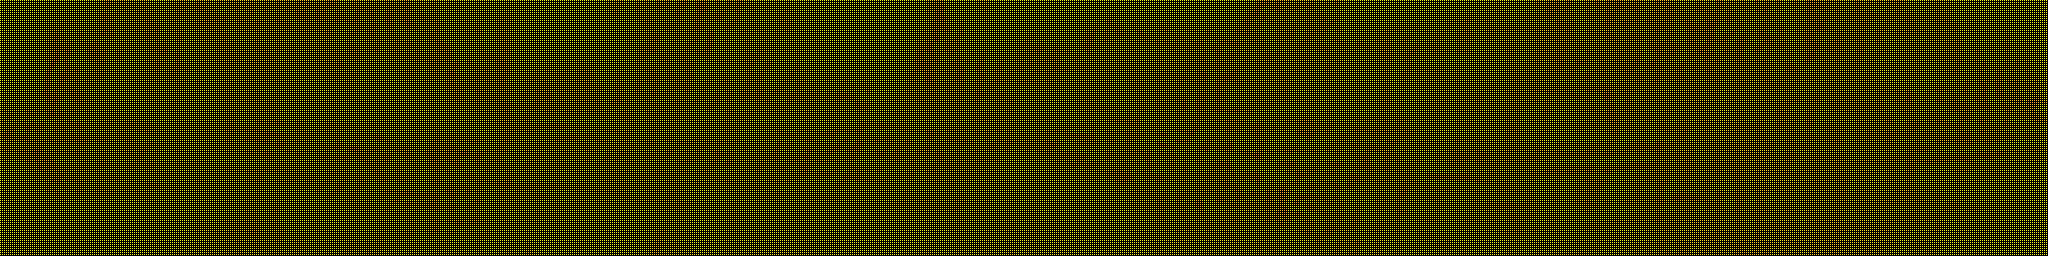

In [20]:
from vidar.datasets.augmentations.resize import resize_npy_preserve, resize_torch_preserve

net_output = depth_net(filtered_batch)

pred_panodepth = inv2depth(net_output['inv_depths'])
output_dict = {'predictions': {'panodepth': {0: pred_panodepth}}}

pred_panodepth = resize_torch_preserve(pred_panodepth[0], (256, 2048)).detach().cpu()

normalizer =None

# normalizer = np.percentile(pred_panodepth[pred_panodepth > 0],50)

display(Image.fromarray(
    (viz_depth(pred_panodepth, normalizer=normalizer) * 255.0).astype(np.uint8)
))     

In [20]:
pred_panodepth.size()

torch.Size([1, 256, 2048])

In [21]:
panodepth=filtered_batch['camera_pano']['depth']
panodepth.shape

torch.Size([1, 1, 256, 2048])

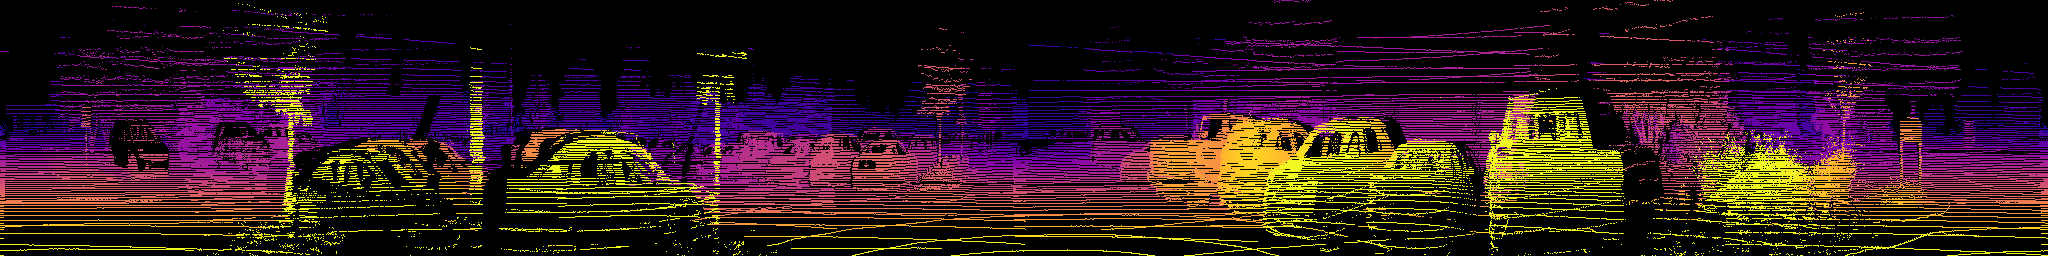

In [22]:
display(Image.fromarray(
    ((viz_depth(panodepth, filter_zeros=False)) * 255.0).astype(np.uint8)
))     

In [23]:
pred_panodepth = inv2depth(net_output['inv_depths'])
output_dict = {'predictions': {'panodepth': {0: pred_panodepth}}}

# depth_gt, pano_image = self.to_per_camera_depth(batch, pred_panodepth)
output_dict['predictions']['depth'] = [pred_panodepth]
import ipdb; ipdb.set_trace()


camera_names = list(filter(lambda k: k.startswith('camera_0'), batch.keys()))
output_dict['batch'] = {
    'depth': {0: torch.stack([batch[cam_name]['depth'][0] for cam_name in camera_names], axis=1)},
    'sensor_name': [[n] for n in camera_names],
    **batch
}
output_dict['batch']['camera_pano']['rgb'] = {0: pano_image}

if not self.training:
    return output_dict

losses = self.compute_losses(pano_image, pred_panodepth, depth_gt)
return {'loss': losses['loss'], 'metrics': losses['metrics'], 'predictions': {'depth': {0: pred_panodepth}}}

def compute_losses(self, rgb, depths, gt_depths):
"""Compute supervised and smoothness losses for depth estimation."""
tgt = 0
rgbs = make_rgb_scales(rgb, depths)



supervision_output = self.losses['supervised'](depths[0][0], gt_depths[tgt])
loss = supervision_output['loss']
metrics = {**supervision_output['metrics']}

smoothness_output = self.losses['smoothness'](rgbs, depths)
loss = supervision_output['loss'] + smoothness_output['loss']
metrics = {**supervision_output['metrics'], **smoothness_output['metrics']}

return {'loss': loss, 'metrics': metrics}

IndentationError: expected an indented block (2836331333.py, line 24)